In [2]:
#IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold

### Data Preprocessing

In [3]:
df = pd.read_csv('diabetes.csv')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print((df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0).sum())
#need to find a way to handle these zeroes

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


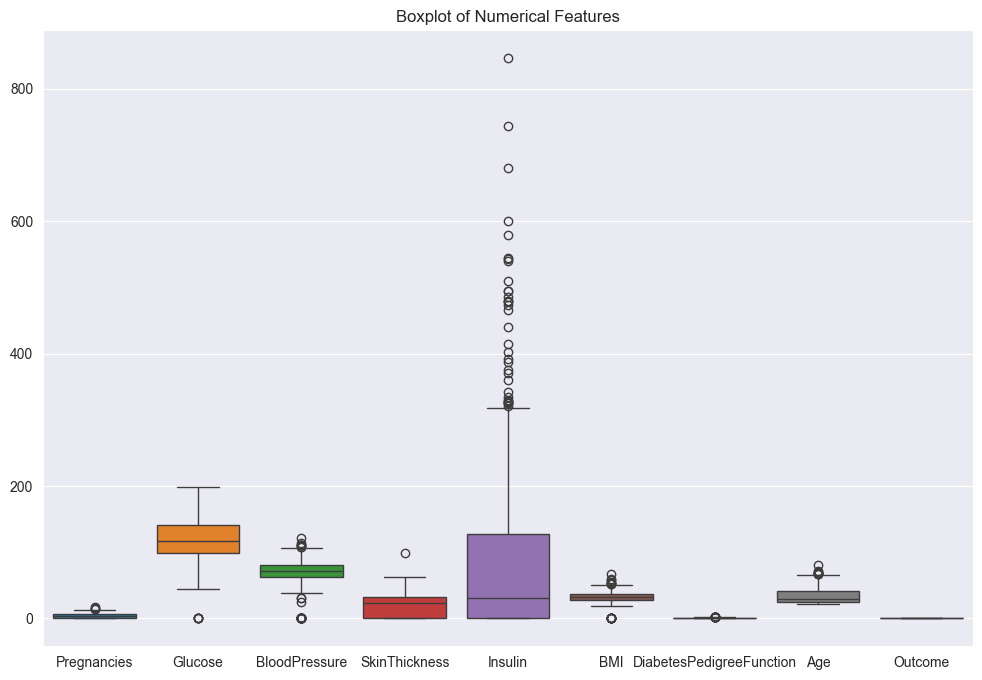

In [5]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.title('Boxplot of Numerical Features')
plt.show()

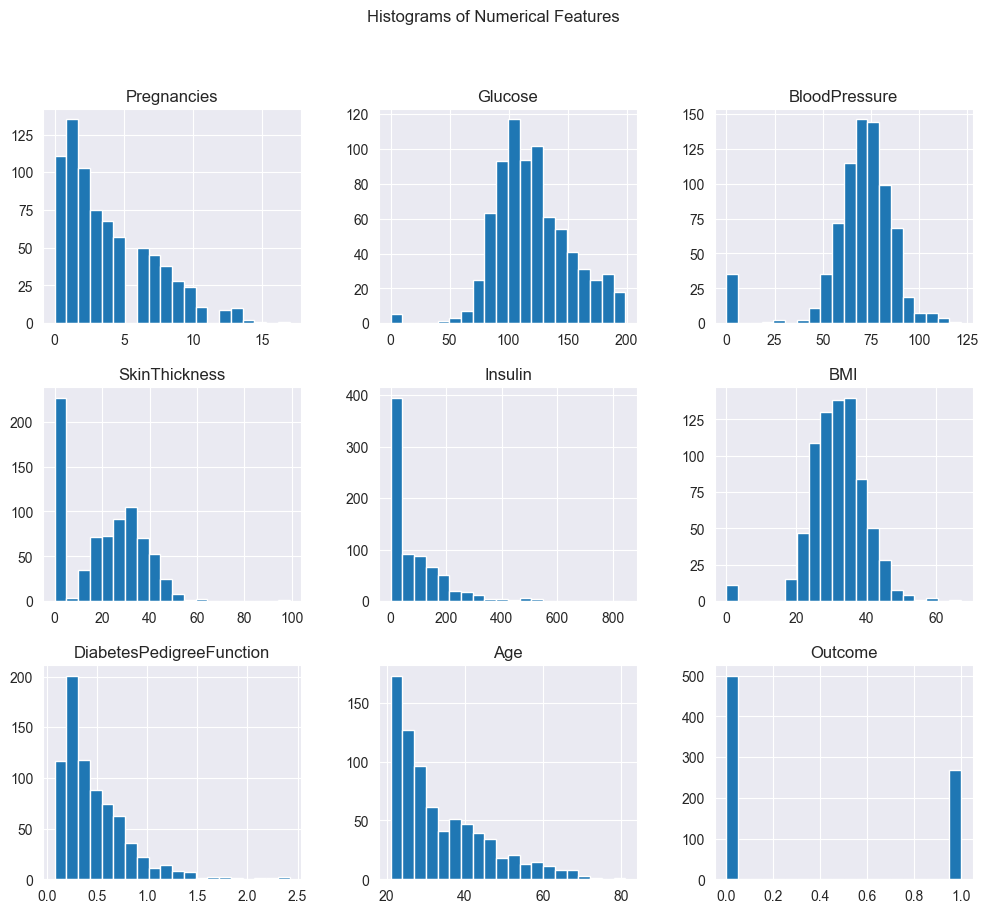

In [6]:
df.hist(figsize=(12, 10), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()#

###### Handle zeroes at ***$Glucose$, $BloodPressure$, $SkinThickness$, $Insulin$, $BMI$***

In [7]:
#replace NaN with median of the column grouped by the target
df['Glucose'] = df['Glucose'].replace(0, np.nan)
median_glucose = df.groupby('Outcome')['Glucose'].median()
df['Glucose'] = df.apply(lambda x: median_glucose[x['Outcome']] if pd.isnull(x['Glucose']) else x['Glucose'], axis=1)
df['Glucose'].isnull().sum()
# glucose done!

0

In [8]:
#blood pressure
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
median_blood_pressure = df.groupby('Outcome')['BloodPressure'].median()
df['BloodPressure'] = df.apply(lambda x: median_blood_pressure[x['Outcome']] if pd.isnull(x['BloodPressure']) else x['BloodPressure'], axis=1)
df['BloodPressure'].isnull().sum()
#blood pressure done!

0

In [9]:
#skin thickness
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan)
median_skin_thickness = df.groupby('Outcome')['SkinThickness'].median()
df['SkinThickness'] = df.apply(lambda x: median_skin_thickness[x['Outcome']] if pd.isnull(x['SkinThickness']) else x['SkinThickness'], axis=1)
df['SkinThickness'].isnull().sum()
#skin thickness done!

0

In [10]:
#insulin
df['Insulin'] = df['Insulin'].replace(0, np.nan)
median_insulin = df.groupby('Outcome')['Insulin'].median()
df['Insulin'] = df.apply(lambda x: median_insulin[x['Outcome']] if pd.isnull(x['Insulin']) else x['Insulin'], axis=1)
df['Insulin'].isnull().sum()
#insulin done!

0

In [11]:
#BMI
df['BMI'] = df['BMI'].replace(0, np.nan)
median_bmi = df.groupby('Outcome')['BMI'].median()
df['BMI'] = df.apply(lambda x: median_bmi[x['Outcome']] if pd.isnull(x['BMI']) else x['BMI'], axis=1)
df['BMI'].isnull().sum()
#BMI done!

0

### Feature Engineering

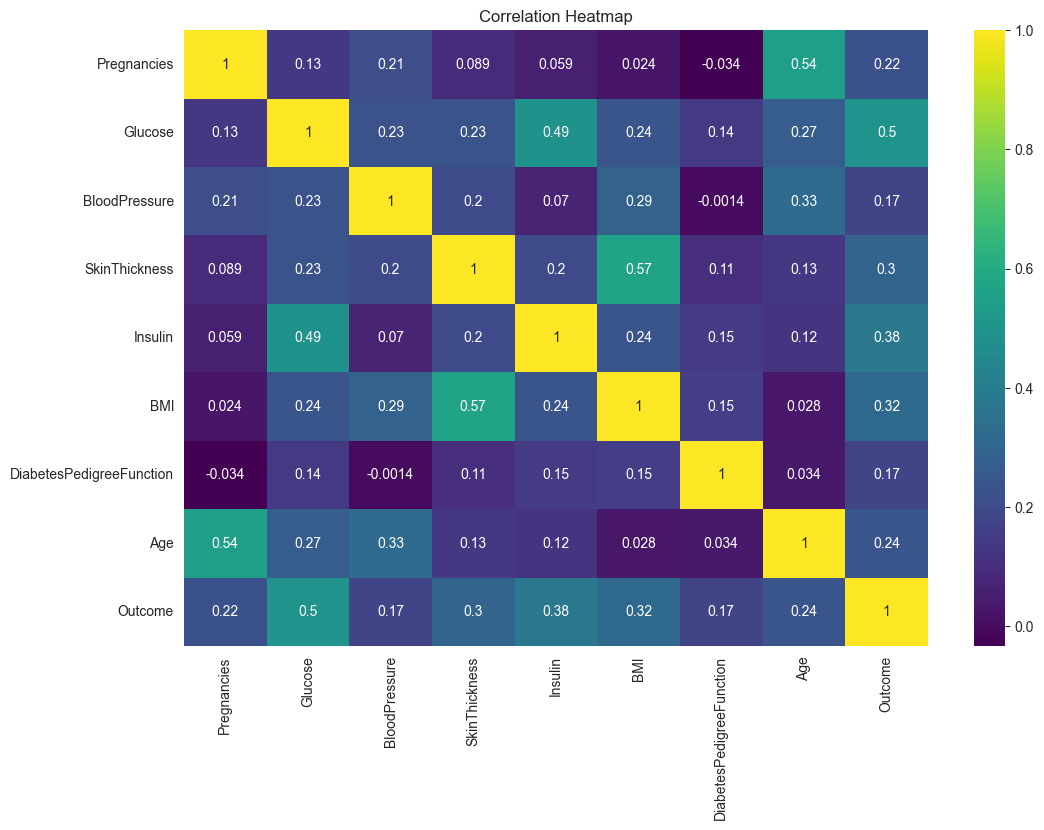

In [12]:
#analyze relationship between features and target, detect most important features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

* I want to use all features, because they all have a significant correlation with the target
* However, there are some strong correlations between features, maybe can use it to reduce dimensionality
    * Glucose and Insulin
    * SkinThickness and BMI
    * BP and Age
    * Pregnancies and Age


In [13]:
#also I can definitely say pregnancy > 0 means, data is women if age is bigger than 16 maybe
#younger than 16, pregnancy is not likely, so doesn't say anything about sex
#but don't forget to read the data as if isWoman == 1 definitely woman, if isWoman == 0, not necessarily man or woman!!!!
df['isWoman'] = df.apply(lambda x: 1 if x['Pregnancies'] > 0 and x['Age'] > 16 else 0, axis=1)

In [14]:
#I would like to see if number of pregnancies effects outcome, or just 0 - 1 relationship
#groupby pregnancies and outcome, and see the mean of outcome
df.groupby('Pregnancies')['Outcome'].mean()

Pregnancies
0     0.342342
1     0.214815
2     0.184466
3     0.360000
4     0.338235
5     0.368421
6     0.320000
7     0.555556
8     0.578947
9     0.642857
10    0.416667
11    0.636364
12    0.444444
13    0.500000
14    1.000000
15    1.000000
17    1.000000
Name: Outcome, dtype: float64

* It seems like 0 - 6 have similar means, 7 - 9 higher
* I can create two groups according to pregnancy, 0, 1-6, 7-9

In [15]:
df['Pregnancies'] = df.apply(lambda x: 0 if x['Pregnancies'] == 0 else 1 if x['Pregnancies'] < 7 else 2, axis=1)

In [16]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,isWoman
0,1,148.0,72.0,35.0,169.5,33.6,0.627,50,1,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,1
2,2,183.0,64.0,32.0,169.5,23.3,0.672,32,1,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0


* I would also like to group ages and BMI because they seem like more useful as categorical
* Plot to decide groups for their relation with the target

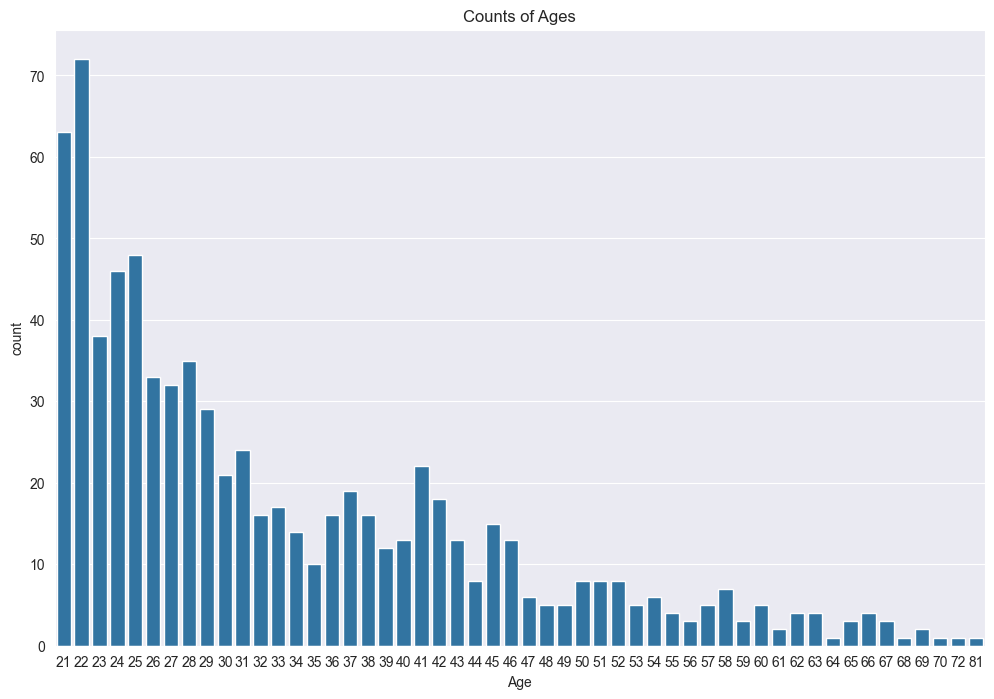

In [17]:
#age and counts of age
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Age')
plt.title('Counts of Ages')
plt.show()

In [18]:
#age-outcome means grouped by age
df['AgeGroup'] = pd.cut(df['Age'], 15)
df.groupby('AgeGroup')['Outcome'].mean()

C:\Users\byzan\AppData\Local\Temp\ipykernel_16828\2720116627.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('AgeGroup')['Outcome'].mean()


AgeGroup
(20.94, 25.0]    0.168539
(25.0, 29.0]     0.302326
(29.0, 33.0]     0.487179
(33.0, 37.0]     0.423729
(37.0, 41.0]     0.507937
(41.0, 45.0]     0.574074
(45.0, 49.0]     0.517241
(49.0, 53.0]     0.724138
(53.0, 57.0]     0.444444
(57.0, 61.0]     0.470588
(61.0, 65.0]     0.166667
(65.0, 69.0]     0.300000
(69.0, 73.0]     0.500000
(73.0, 77.0]          NaN
(77.0, 81.0]     0.000000
Name: Outcome, dtype: float64

* There is a big leap after 33, however not many people after 45-50 to make a decision
* I will group them as 0-33, 34-45, 46-81
* 0 - 33 affect outcome negatively, 34-45 affect outcome positively, 46-81 doesn't affect outcome
* 0-33: -1
* 34-45: 1
* 46-81: 0

In [19]:
df['Age'] = df.apply(lambda x: -1 if x['Age'] < 34 else 1 if x['Age'] < 46 else 0, axis=1)
df.drop('AgeGroup', axis=1, inplace=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,isWoman
0,1,148.0,72.0,35.0,169.5,33.6,0.627,0,1,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,-1,0,1
2,2,183.0,64.0,32.0,169.5,23.3,0.672,-1,1,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,-1,0,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,-1,1,0


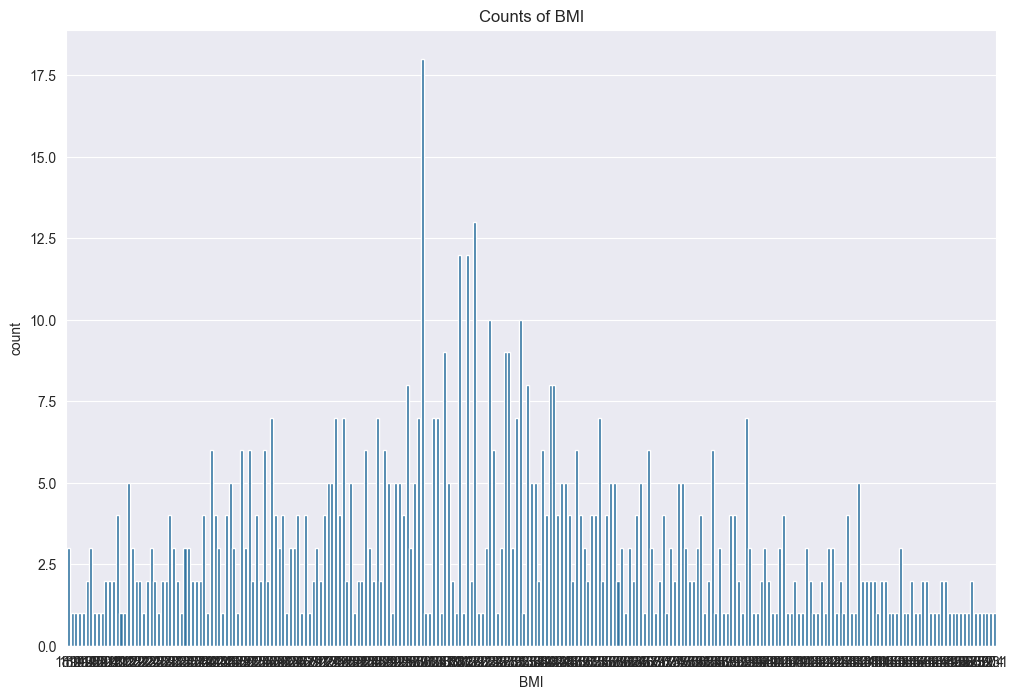

In [20]:
#same reasoning for BMI
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='BMI')
plt.title('Counts of BMI')
plt.show()

In [21]:
df['BMIGroup'] = pd.cut(df['BMI'], 10)
df.groupby('BMIGroup')['Outcome'].mean()

C:\Users\byzan\AppData\Local\Temp\ipykernel_16828\2235462055.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('BMIGroup')['Outcome'].mean()


BMIGroup
(18.151, 23.09]    0.019231
(23.09, 27.98]     0.161491
(27.98, 32.87]     0.360976
(32.87, 37.76]     0.446154
(37.76, 42.65]     0.450549
(42.65, 47.54]     0.541667
(47.54, 52.43]     0.800000
(52.43, 57.32]     0.750000
(57.32, 62.21]     1.000000
(62.21, 67.1]      1.000000
Name: Outcome, dtype: float64

We can clearly see that BMI has a positive effect on the outcome, and can be grouped
18-27, 28-40, 41-55, 56-67

In [22]:
df['BMI'] = df.apply(lambda x: 0 if x['BMI'] < 28 else 1 if x['BMI'] < 41 else 2 if x['BMI'] < 56 else 3, axis=1)
df.drop('BMIGroup', axis=1, inplace=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,isWoman
0,1,148.0,72.0,35.0,169.5,1,0.627,0,1,1
1,1,85.0,66.0,29.0,102.5,0,0.351,-1,0,1
2,2,183.0,64.0,32.0,169.5,0,0.672,-1,1,1
3,1,89.0,66.0,23.0,94.0,1,0.167,-1,0,1
4,0,137.0,40.0,35.0,168.0,2,2.288,-1,1,0


* Here is what I've done up until now:
    * Replaced zeroes(nans) with median of the column grouped by the target
    * Created a new feature isWoman
    * Grouped Pregnancies, Age, BMI
   

### Model Building

In [23]:
#split the data
X = df.drop('Outcome', axis=1)
y = df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [24]:
#scale
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

#### Traditional Machine Learning Models

In [25]:
#logistic reg
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_val)
print(accuracy_score(y_val, y_pred))

0.7922077922077922


In [26]:
#random forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)
print(accuracy_score(y_val, y_pred))

0.8311688311688312


In [27]:
#cross validation
print(cross_val_score(log_reg, x_val, y_val, cv=5).mean())
print(cross_val_score(rf, x_val, y_val, cv=5).mean())

0.8074999999999999
0.8583333333333332


In [28]:
#test set
y_pred = log_reg.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8051948051948052


In [29]:
y_pred = rf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8701298701298701


We can clearly see that random forest is better than logistic regression
Now I will try to build a neural network

#### Neural Network

In [30]:
def create():
    m = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    m.compile(optimizer='adam', loss='binary_crossentropy',
    metrics=['accuracy'])
    return m

#wrap with classifier to use cross_val_score
model = KerasClassifier(model=create, epochs=100, batch_size=32, verbose=0)

In [31]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_val_score(model, x_train, y_train, cv=kfold)
res

array([0.84552846, 0.82926829, 0.82113821, 0.82926829, 0.83606557])

In [32]:
y_pred = model.fit(x_train, y_train).predict(x_val)
print(accuracy_score(y_val, y_pred))

0.8181818181818182


In [33]:
#let's also check the test set
y_pred = model.fit(x_train, y_train).predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8701298701298701


I can see that the neural network is not as good as the random forest
I will try to improve my neural network however, it is possible that nn will always overfit because it is a small dataset

In [34]:
def create():
    m = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    m.compile(optimizer='adam', loss='binary_crossentropy',
    metrics=['accuracy'])
    return m

#wrap with classifier to use cross_val_score
model = KerasClassifier(model=create, epochs=100, batch_size=32, verbose=0)

In [35]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_val_score(model, x_train, y_train, cv=kfold)
res

array([0.86178862, 0.83739837, 0.82926829, 0.86178862, 0.86885246])

In [36]:
y_pred = model.fit(x_train, y_train).predict(x_val)
print(accuracy_score(y_val, y_pred))


0.8181818181818182


In [37]:
#let's also check the test set
y_pred = model.fit(x_train, y_train).predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8571428571428571


In [38]:
#I will also try to use dropout
def create():
    m = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    m.compile(optimizer='adam', loss='binary_crossentropy',
    metrics=['accuracy'])
    return m

#wrap with classifier to use cross_val_score
model = KerasClassifier(model=create, epochs=100, batch_size=32, verbose=0)

In [39]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
res = cross_val_score(model, x_train, y_train, cv=kfold)
res

array([0.84552846, 0.84552846, 0.82113821, 0.79674797, 0.8442623 ])

In [40]:
y_pred = model.fit(x_train, y_train).predict(x_val)
print(accuracy_score(y_val, y_pred))

0.8571428571428571


In [41]:
#let's also check the test set
y_pred = model.fit(x_train, y_train).predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8701298701298701


In [42]:
#wow, it got worse, let's improve the model
def create():
    m = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
    m.compile(optimizer='adam', loss='binary_crossentropy',
    metrics=['accuracy'])
    return m

model = KerasClassifier(model=create, epochs=100, batch_size=32, verbose=0)

In [43]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [44]:
res = cross_val_score(model, x_train, y_train, cv=kfold)
res

array([0.87804878, 0.82113821, 0.80487805, 0.82113821, 0.8442623 ])

In [45]:
y_pred = model.fit(x_train, y_train).predict(x_val)
print(accuracy_score(y_val, y_pred))

0.8311688311688312


In [46]:
y_pred = model.fit(x_train, y_train).predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8701298701298701


In [47]:
#I think nn is overkill, maybe I can try to improve random forest
rf = RandomForestClassifier(n_estimators=300, max_depth=15)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)
print(accuracy_score(y_val, y_pred))

0.8311688311688312


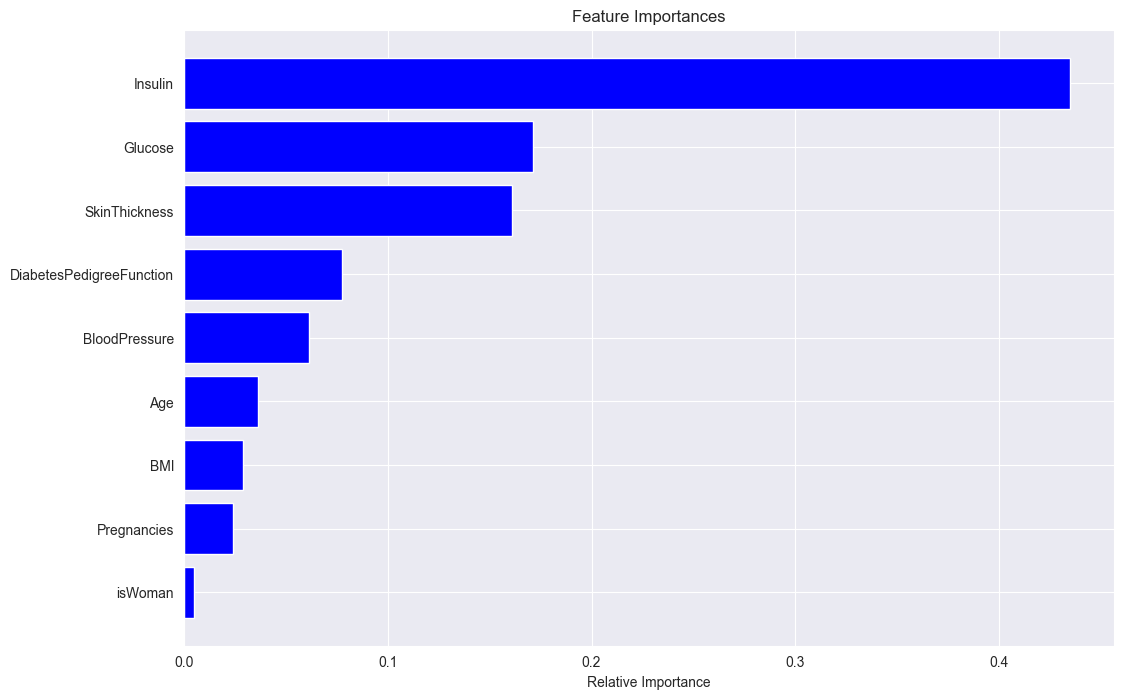

In [48]:
#maybe use less feature, by using feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [49]:
#I will use only the top 4 features
X = df[['Glucose', 'BMI', 'Age', 'Insulin']]
y = df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [50]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)
print(accuracy_score(y_val, y_pred))

0.8311688311688312


In [51]:
y_pred = rf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8831168831168831


In [52]:
def test(est, depth):
    r = RandomForestClassifier(n_estimators=est, max_depth=depth)
    rf.fit(x_train, y_train)
    y_p = rf.predict(x_val)
    print(accuracy_score(y_val, y_p))
    y_p = rf.predict(x_test)
    print(accuracy_score(y_test, y_pred))

In [53]:
est = [5,8,10,12,15,20]
depth = [2,3,4,5,6]
for e in est:
    for d in depth:
        print(f'Est: {e}, Depth: {d}')
        test(e, d)

Est: 5, Depth: 2
0.8441558441558441
0.8831168831168831
Est: 5, Depth: 3
0.8311688311688312
0.8831168831168831
Est: 5, Depth: 4
0.8441558441558441
0.8831168831168831
Est: 5, Depth: 5
0.8311688311688312
0.8831168831168831
Est: 5, Depth: 6
0.8441558441558441
0.8831168831168831
Est: 8, Depth: 2
0.8441558441558441
0.8831168831168831
Est: 8, Depth: 3
0.8571428571428571
0.8831168831168831
Est: 8, Depth: 4
0.8701298701298701
0.8831168831168831
Est: 8, Depth: 5
0.8311688311688312
0.8831168831168831
Est: 8, Depth: 6
0.8311688311688312
0.8831168831168831
Est: 10, Depth: 2
0.8571428571428571
0.8831168831168831
Est: 10, Depth: 3
0.8311688311688312
0.8831168831168831
Est: 10, Depth: 4
0.8701298701298701
0.8831168831168831
Est: 10, Depth: 5
0.8441558441558441
0.8831168831168831
Est: 10, Depth: 6
0.8311688311688312
0.8831168831168831
Est: 12, Depth: 2
0.8441558441558441
0.8831168831168831
Est: 12, Depth: 3
0.8441558441558441
0.8831168831168831
Est: 12, Depth: 4
0.8701298701298701
0.8831168831168831
Es

In [55]:
#increasing depth and estimators didn't help, there was something wrong with the model
#I will try to use the top 5 features
X = df[['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure', "SkinThickness"]]
y = df['Outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [56]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_val)
print(accuracy_score(y_val, y_pred))


0.8311688311688312


In [57]:
y_pred = rf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8571428571428571
